## Objective

OCR(optical character recognition)은 이미지 내 글자를 인식하는 연구로, 컴퓨터 비전의 실용 분야 중 하나입니다. OCR 문제는 문서나 차량번호판 등 특정한 포맷이 있는 상황에서는 잘 동작하나, 일반적인 환경에서는 글자를 아직 잘 인식하지 못하고 있습니다. 그래서 OCR을 딥러닝을 활용해 해결해 보자가 많이 화두가 되었습니다.

<img width="582" src="https://user-images.githubusercontent.com/66022630/84572437-ea12e400-add4-11ea-819e-11ae0e6694a7.png">


OCR은 크게 두 단계로 나뉘어 집니다. 글자의 위치를 인식하는 Text Detection과 어떤 글자의 Sequence로 이루어져 있는지를 인식하는 Text Recognition으로 나눌 수 있습니다. 이번 프로젝트에서는 Text Recognition을 중심으로 해결해보도록 하겠습니다. 

Text Recognition은 순서대로 배치된 글자를 읽어들이는 알고리즘입니다. Classification를 순서에 맞게 반복적으로 수행해야 합니다. 우선 간단한 MNIST를 Text Recognition 문제로 변형시킨 후 풀어보도록 하겠습니다.

In [2]:
%matplotlib inline
import sys
import cv2
import numpy as np
    
import tensorflow as tf 
import matplotlib.pyplot as plt

### MNIST 데이터셋

MNIST 데이터셋을 통해 정상적으로 동작하는지를 확인해 보도록 합니다.

#### - 데이터 가져오기 

In [3]:
sys.path.append("../")
from utils.dataset import SerializationDataset

train_set = SerializationDataset('mnist','train',
                                 digit=5,pad_range=(3,10))
validation_set = SerializationDataset('mnist','validation',
                                      digit=5,pad_range=(3,10))
test_set = SerializationDataset('mnist','test',
                                digit=(3,8),pad_range=(3,10))

18296397/18296397 [==============================] - 2s 0us/step


#### - 데이터 Generator 가져오기

In [4]:
from utils.generator import DataGenerator

train_gen = DataGenerator(train_set, batch_size=32)
valid_gen = DataGenerator(validation_set, batch_size=100, shuffle=False)
test_gen = DataGenerator(test_set, batch_size=500, shuffle=False)

c:\Users\ririk\anaconda3\envs\py39\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


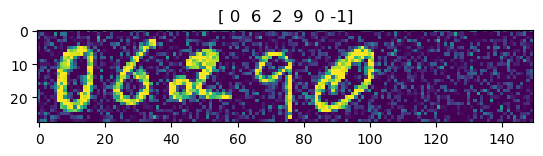

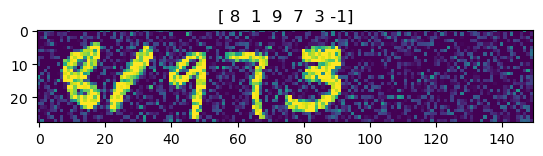

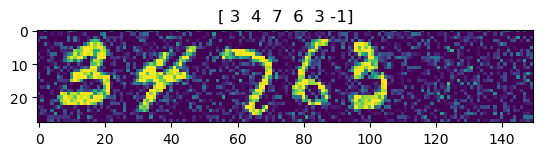

In [5]:
images, labels = train_gen[0]
for i in range(3):
    plt.title(labels[i])
    plt.imshow(images[i,:,:,0])
    plt.show()

### CRNN 모델 구성하기

가장 대표적인 Text Recognition 모델은 바로 CRNN Model입니다.

![](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile26.uf.tistory.com%2Fimage%2F996F92435D4AED4516D1FD)

이 모델은 Convolution Layer와 RNN으로 구성되어 있고, Loss는 CTC-Loss를 사용했습니다. 아래에서 단계별로 구현하며 살펴보도록 하겠습니다.

### Convolution Feature Extractor 부분 구성하기

VGG Style Layer 구성방식을 택했습니다. 기존과 좀 다른 구성은 Maxpooling layer에 있는데, 이는 마지막 두개의 Maxpooling은 Height 방향으로만 Pooling을 적용했습니다. Pooling을 할수록 이후 가능한 출력의 최대 길이가 줄어들게 됩니다. 가능한 출력의 최대 길이보다 실제 단어가 더 많으면 올바르게 동작할 수 없기 때문에, 우리는 비대칭적으로 width방향은 줄지 않도록 막았습니다.

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


inputs = Input(shape=(28,None,1)) # Shape : (batch, height, width, channel)
conv1 = Conv2D(64, (3, 3), activation='relu',
               padding='same',name='conv1')(inputs)
maxpool1 = MaxPooling2D((2, 2), (2, 2),
                        padding='same',name='maxpool1')(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu',
               padding='same',name='conv2')(maxpool1)
maxpool2 = MaxPooling2D((2, 2), (2, 2),
                        padding='same',name='maxpool2')(conv2)
conv3 = Conv2D(256, (3, 3), activation='relu',
               padding='same',name='conv3')(maxpool2)
conv4 = Conv2D(256, (3, 3), activation='relu',
               padding='same',name='conv4')(conv3)
maxpool3 = MaxPooling2D((2, 1), (2, 1),
                        padding='same',name='maxpool3')(conv4)
batchnorm1 = BatchNormalization(name='batchnorm1')(maxpool3)
conv5 = Conv2D(512, (3, 3), activation='relu', 
               padding='same',name='conv5')(batchnorm1)
batchnorm2 = BatchNormalization(name='batchnorm2')(conv5)
conv6 = Conv2D(512, (3, 3), activation='relu',
               padding='same', name='conv6')(batchnorm2)
maxpool4 = MaxPooling2D((2, 1), (2, 1),
                        padding='same',name='maxpool4')(conv6)
conv7 = Conv2D(512, (2, 2), activation='relu',
               padding='valid',name='conv7')(maxpool4)


### Map to Sequence 부분 구성하기

Convolution Layer을 통과하고 나면<br>
````
Shape : (batch_size, feature_map_height, feature_map_width, num_features)
````
로 구성됩니다.

현재 글자는 X축 방향으로 진행되고 있기 때문에, x축 방향이 time step 방향이 됩니다. RNN의 Input으로 넣기 위해 <br>
````
Shape : (batch_size, feature_map_width, feature_map_height * num_features)
````
으로
바꾸어주어야 합니다.

In [7]:
transposed = tf.transpose(conv7,(0,2,1,3))

shape = tf.shape(transposed) # Dynamic Shape
_, _, h, c = transposed.get_shape().as_list() # Static Shape

feature_sequence = tf.reshape(transposed, 
                              shape=[shape[0],shape[1],h*c])

feature_sequence

<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'tf.reshape')>

### Stacked BLSTM 레이어 구성하기

총 2층의 Bidirectional LSTM Layer가 구성됩니다.

In [8]:
from tensorflow.keras.layers import Bidirectional, LSTM

x = Bidirectional(LSTM(256, return_sequences=True))(feature_sequence)
lstm_seqs = Bidirectional(LSTM(256, return_sequences=True))(x)

### CTC Loss 구성하기

CTC(Connectionist Temporal Classification)는 학습데이터에 클래스 라벨만 순서대로 존재하고 각 클래스의 위치는 어디에 있는지 모르는 Unsegmented 시퀀스 데이터의 학습을 위해서 사용하는 알고리즘입니다. <br>

![Imgur](https://i.imgur.com/DDqq7j6.png)

#### - LSTM의 출력 길이

모델을 Feed Forward하여 나온 출력 Sequence의 길이는 여기 영상에 있는 단어 수보다는 보통 훨씬 더 많습니다.

#### - 출력으로 가능한 후보군들

![Imgur](https://i.imgur.com/TbrHxZr.png)

CTC 알고리즘은 가능한 출력의 조합을 모두 구해, Loss를 계산하는 방식입니다. 수많은 조합이 있기 때문에, CTC 알고리즘은 Loss를 계산하기 위해, Dynamic Programming을 이용합니다.

#### - CTC 알고리즘을 통한 Loss 계산하기

![Imgur](https://i.imgur.com/4d2z1mY.png)

위와 같은 방식으로 재귀적으로 그다음 Step의 Loss를 계산합니다. 다음 경로로 이어질 수 있는 케이스는 (1) 공백 (2) 현재와 동일한 글자 (3) 다음 등장할 글자로, 이 3가지 케이스에 대한 조합으로 경로가 구성됩니다. 텐서플로우와 케라스에서는 이를 계산하는 메소드를 제공해줍니다.

In [9]:
def ctc_loss(y_true, y_pred):
    """
    Runs CTC Loss Algorithm on each batch element

    :param y_true: tensor (samples, max_string_length) containing the truth labels.
    :param y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.

    * caution

    input_length : tensor (samples, 1) containing the sequence length for each batch item in y_pred
    label_length : tensor (samples, 1) containing the sequence length for each batch item in y_true

    y_true는 [3,7,12,1,2,-1,-1,-1,-1] 와 같은 형태로 구성되어 있음. -1은 Blank를 의미
    처음 등장하는 -1의 인덱스가 y_true의 sequnece length와 동일

    y_pred의 총 width와 input_length는 동일

    """

    # Get the Length of Prediction
    shape = tf.shape(y_pred)
    batch_size = shape[0]
    max_length = shape[1, None, None]
    input_length = tf.tile(max_length, [batch_size, 1])

    # Get the Length of Input
    label_length = tf.argmin(y_true, axis=-1)[:, None]

    return K.ctc_batch_cost(y_true, y_pred,
                            input_length, label_length)


#### - 결과 추론하기

![Imgur](https://i.imgur.com/yeZbwtx.png)

각 단계 별로 가장 높은 확률을 보인 출력값을 계산합니다. 여기서 핵심 문제는 각 단계에서 가장 높은 확률이 꼭 전체 시퀀스의 확률이 최대화되는 것을 보장하지 못한다는 것에 있습니다. 그렇다고, 모든 케이스를 다 살펴보기에는 매우 탐색 비용이 크게 듭니다. 그 가운데에서 **적당히** 살펴보는 방법이 있습니다. 이를 Beam Search라 부르고, 아래와 같이 동작합니다.

![Imgur](https://i.imgur.com/n3TS5s1.png)

케라스에서는 위의 과정을 대신 해주는 함수로, `K.ctc_decode`를 제공해줍니다.

In [10]:
from tensorflow.keras.layers import Layer
class CTCDecoder(Layer):
    """
    CRNN 중 Transcription Layer에 해당하는 Module Class

    * beam_width :
      클수록 탐색하는 Candidate Sequence가 많아져 정확도는 올라가나,
      연산 비용도 함께 올라가기 때문에 ACC <-> Speed의 Trade-Off 관계에 있음

    """
    def __init__(self, beam_width=100, **kwargs):
        self.beam_width = beam_width
        super().__init__(**kwargs)

    def call(self, inputs, **kwargs):
        shape = tf.shape(inputs)
        batch_size = shape[0]
        max_length = shape[1, None]
        input_length = tf.tile(max_length, [batch_size])

        prediction, scores = K.ctc_decode(inputs, input_length, beam_width=self.beam_width)
        return [prediction, scores]

    def get_config(self):
        config = {
            "beam_width": self.beam_width
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 모델 전체 구성하기
기 구성된 Custom Layer로 구성해보도록 하겠습니다.

In [13]:
from models.layers import ConvFeatureExtractor, Map2Sequence 
from models.layers import BGRUEncoder, CTCDecoder
from models.losses import ctc_loss
from tensorflow.python.keras.layers import Input, Dense
import keras.backend as K

In [14]:
height = 28
num_classes = 10
n_hidden = 16
n_lstm = 256
K.clear_session()

# For Gray Scale Image & Dynamic width
inputs = Input(shape=(height, None, 1),name='image')

# CRNN Model
conv_maps = ConvFeatureExtractor(n_hidden=n_hidden,
                                 name='feature_extractor')(inputs)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
lstm_seqs, _, _ = BGRUEncoder(n_units=n_lstm)(feature_seqs)

# 우리의 출력 형태는 class 수에 Blank Label을 하나 더해 #classes + 1 만큼을 출력
output_seqs = Dense(num_classes+1,
                    activation='softmax',
                    name='output_seqs')(lstm_seqs)

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'feature_extractor/conv2d/kernel:0' shape=(3, 3, 1, 16) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'feature_extractor/conv2d/bias:0' shape=(16,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'feature_extractor/conv2d_1/kernel:0' shape=(3, 3, 16, 32) dtype=fl

### 모델 컴파일 하기

In [16]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 

# 모델 구성하기
# (1) 학습 모델 구성하기
y_true =  Input(shape=(None,), dtype=tf.int32)
trainer = Model(inputs, output_seqs, name='trainer')
trainer.compile(Adam(1e-3),
                loss={"output_seqs":ctc_loss},
                target_tensors=[y_true])

AttributeError: 'KerasTensor' object has no attribute 'node'

In [34]:
# (2) 예측 모델 구성하기
predictions = CTCDecoder(beam_width=100)(output_seqs)
predictor = Model(inputs, predictions[0], name='predictor')

W0614 01:22:06.394987 4566934976 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/backend.py:5811: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


### 모델  학습시키기

In [35]:
trainer.fit_generator(train_gen, epochs=10,
                      validation_data=valid_gen)

W0614 01:22:07.830340 4566934976 deprecation.py:323] From <ipython-input-35-9275c4ff02ef>:3: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
343/343 [==============================] - 151s 441ms/step - loss: 5.4894 - val_loss: 13.0642
Epoch 2/10
343/343 [==============================] - 135s 392ms/step - loss: 0.5426 - val_loss: 0.4657
Epoch 3/10
343/343 [==============================] - 133s 387ms/step - loss: 0.3860 - val_loss: 0.3065
Epoch 4/10
343/343 [==============================] - 131s 381ms/step - loss: 0.3253 - val_loss: 0.3550
Epoch 5/10
 29/343 [=>............................] - ETA: 2:18 - loss: 0.2093

KeyboardInterrupt: 

### 모델 평가하기

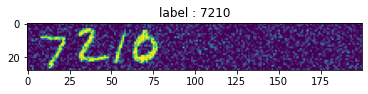

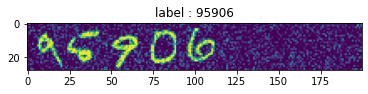

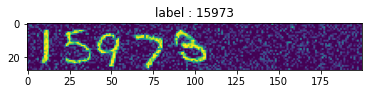

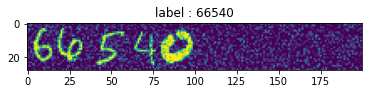

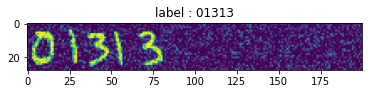

In [40]:
test_gen = DataGenerator(test_set, batch_size=5, shuffle=False)
for image, true_label in zip(*test_gen[0]):
    result = predictor.predict(image[np.newaxis])
    predict_seq = "".join([str(char) for char in result.ravel()])
    plt.title(f'label : {predict_seq}')
    plt.imshow(image[:,:,0])
    plt.show()